In [1]:
from pathlib import Path
from indigo import Indigo
import numpy as np
import pandas as pd
import asyncio

from substrucure_finder import BucketsInitializer
from substrucure_finder import SearchEngine, ThreadPoolSearchEngine

import fp_utils
from fp_utils.finders import Finder
from fp_utils.tests import FinderSpeedTester
from fp_utils.catch_time import CatchTime

In [2]:
fp_utils.settings.init_fp_utils()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
data_path = Path("../data/")

In [4]:
zero_columns_name = '../data/zero_columns'

# Build structure

In [5]:
data_name = ''

In [6]:
initializer = BucketsInitializer(data_path / data_name, columns_count=100)

In [7]:
(data_path / data_name / 'buckets').mkdir(exist_ok=True)

In [ ]:
%%time
initializer.init_buckets()

# Search Queries

In [5]:
with open(zero_columns_name, 'r') as f:
    zero_columns = list(map(int, f.read().split()))
assert list(sorted(zero_columns)) == zero_columns

In [6]:
full_columns = list(sorted(set(range(3736)) - set(zero_columns)))

In [7]:
def bin_format(number, num_of_bits=3736):
    fp = list(map(int, list(bin(int(number, 16))[2:].zfill(num_of_bits))))
    return np.fromiter(fp, dtype=int)

In [8]:
def smiles_to_fingerprint(smiles):
    indigo_mol_to_test = Indigo().loadMolecule(smiles)
    full_fp = bin_format(indigo_mol_to_test.fingerprint("sub").toString())
    return np.fromiter(pd.Series(full_fp)[full_columns].values, dtype=bool)

In [9]:
@CatchTime("search")
def search(smiles: str, finder: Finder, ans_count=None):
    fp = smiles_to_fingerprint(smiles)
    return list(finder.find(fp, ans_count))

In [10]:
class ComplexFinder(SearchEngine, Finder):   
    def find_all(self, fp):
        return self.search(fp)

In [11]:
class ThreadPoolFinder(ThreadPoolSearchEngine, Finder):   
    def find_all(self, fp):
        return self.search(fp)

In [12]:
# mcc100_2kk = ComplexFinder(data_path / '2kk_100_mcc')
# mcc100_2kk_async = AsyncFinder(data_path / '2kk_100_mcc')
# mcc100_17kk_heur2000 = ComplexFinder(data_path / '17kk_100_heur2000')
# mcc100_17kk_heur2000_async = AsyncFinder(data_path / '17kk_100_heur2000')
# mcc100_2kk_heur1000 = ComplexFinder(data_path / '2kk_100_heur1000')
# mcc100_2kk_heur1500 = ComplexFinder(data_path / '2kk_100_heur1500')
# mcc100_2kk_heur1700 = ComplexFinder(data_path / '2kk_100_heur1700')

In [13]:
# mcc100_17kk = ComplexFinder(data_path / '17kk_100_heur2000')

In [14]:
with open('../data/pubchem_994_queries.txt', 'r') as f:
    queries = list(map(lambda x: x.split()[0], f.read().strip().split('\n')))

In [15]:
len(queries), queries[:10]

(157,
 ['Cc1c[n]c2[nH]ccc2c1Cl',
  'OC(=O)c1c[n]c2[nH]ccc2c1Cl',
  'Cc1c(Cl)c[n]c2[nH]ccc21',
  'Oc1c[n]c2[nH]ccc2c1Cl',
  'N[C@@H](C[S@](=O)CCO)C(O)=O',
  'OC(=O)c1ccc2[nH]ccc2[n]1',
  'N[C@@H](C[S@@](=O)CCO)C(O)=O',
  'COC(=O)[C@@H](O)CC([O-])=O',
  'OC(=O)c1[n]ccc2[nH]ccc21',
  'CC[NH2+]CC(C)C'])

In [16]:
queries_fp = [smiles_to_fingerprint(smiles) for smiles in queries]

In [17]:
import random

In [18]:
queries_30 = random.sample(queries_fp, 30)

In [19]:
mcc100_17kk_heur2000 = ComplexFinder(data_path / '17kk_100_heur2000')

0.156s -- ComplexFinder init time


In [20]:
%%time 
stat_sync = FinderSpeedTester([mcc100_17kk_heur2000]).test_all(queries_30, verbose=True, ans_count=10)

-----
Test #000
0.053 -- ComplexFinder
-----
Test #001
4.735 -- ComplexFinder
-----
Test #002
0.900 -- ComplexFinder
-----
Test #003
9.567 -- ComplexFinder
-----
Test #004
0.005 -- ComplexFinder
-----
Test #005
0.640 -- ComplexFinder
-----
Test #006
2.290 -- ComplexFinder
-----
Test #007
2.204 -- ComplexFinder
-----
Test #008
1.711 -- ComplexFinder
-----
Test #009
0.009 -- ComplexFinder
-----
Test #010
1.995 -- ComplexFinder
-----
Test #011
0.029 -- ComplexFinder
-----
Test #012
29.605 -- ComplexFinder
-----
Test #013
1.565 -- ComplexFinder
-----
Test #014
0.045 -- ComplexFinder
-----
Test #015
0.736 -- ComplexFinder
-----
Test #016
5.260 -- ComplexFinder
-----
Test #017
0.976 -- ComplexFinder
-----
Test #018
0.116 -- ComplexFinder
-----
Test #019
0.025 -- ComplexFinder
-----
Test #020
15.057 -- ComplexFinder
-----
Test #021
8.455 -- ComplexFinder
-----
Test #022
2.632 -- ComplexFinder
-----
Test #023
4.663 -- ComplexFinder
-----
Test #024
2.022 -- ComplexFinder
-----
Test #025
0.048 -

In [21]:
mcc100_17kk_heur2000_async = ThreadPoolFinder(data_path / '17kk_100_heur2000')

0.228s -- ThreadPoolFinder init time


In [22]:
%%time 
stat_async = FinderSpeedTester([mcc100_17kk_heur2000_async]).test_all(queries_30, verbose=True, ans_count=10)

-----
Test #000
del executor
0.761 -- ThreadPoolFinder
-----
Test #001
del executor
4.271 -- ThreadPoolFinder
-----
Test #002
del executor
1.149 -- ThreadPoolFinder
-----
Test #003
del executor
12.377 -- ThreadPoolFinder
-----
Test #004
del executor
0.367 -- ThreadPoolFinder
-----
Test #005
del executor
1.221 -- ThreadPoolFinder
-----
Test #006
del executor
2.691 -- ThreadPoolFinder
-----
Test #007
del executor
3.750 -- ThreadPoolFinder
-----
Test #008
del executor
2.986 -- ThreadPoolFinder
-----
Test #009
del executor
0.296 -- ThreadPoolFinder
-----
Test #010
del executor
2.557 -- ThreadPoolFinder
-----
Test #011
del executor
0.466 -- ThreadPoolFinder
-----
Test #012
del executor
26.376 -- ThreadPoolFinder
-----
Test #013
del executor
1.459 -- ThreadPoolFinder
-----
Test #014
del executor
0.424 -- ThreadPoolFinder
-----
Test #015
del executor
1.086 -- ThreadPoolFinder
-----
Test #016
del executor
4.720 -- ThreadPoolFinder
-----
Test #017
del executor
1.264 -- ThreadPoolFinder
-----
Te

In [23]:
stat = stat_sync + stat_async

In [24]:
stat

ComplexFinder:
	0.005 -- min
	29.605 -- max
	3.457 -- mean
	1.638 -- median
ThreadPoolFinder:
	0.296 -- min
	26.376 -- max
	3.505 -- mean
	1.449 -- median

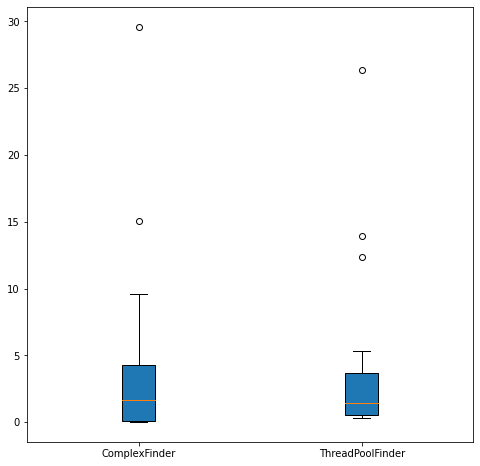

In [25]:
stat.as_boxplot()

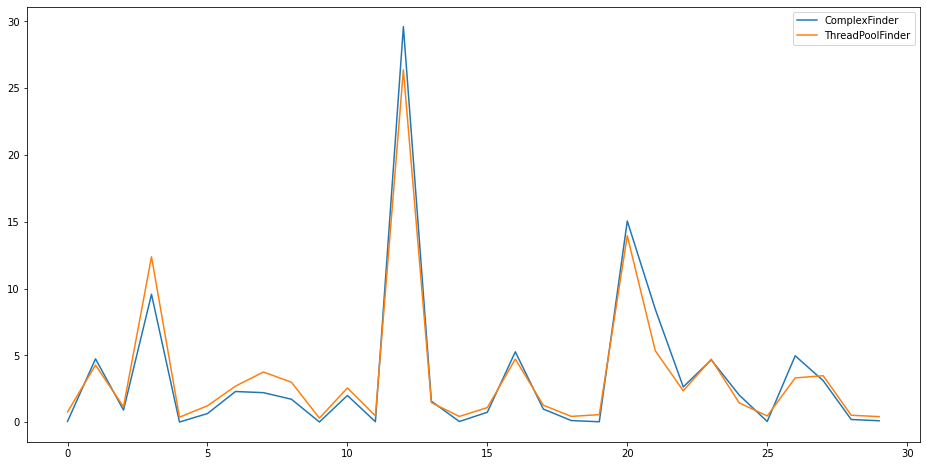

In [26]:
stat.as_plot()

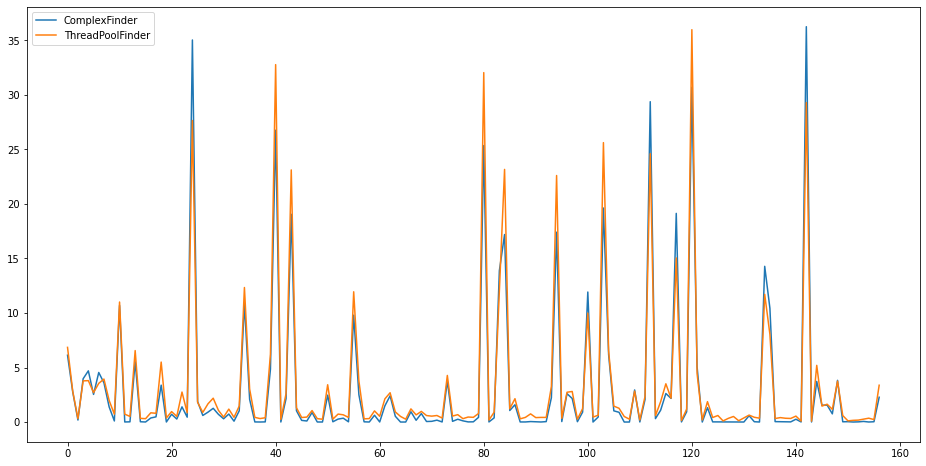

In [26]:
stat.as_plot()

In [ ]:
from fp_utils.draw import MoleculeDrawer

In [ ]:
query = queries[0]
MoleculeDrawer.draw_one(query)

In [ ]:
answers = search(query, mcc100_17kk_heur2000_async, ans_count=10)

In [ ]:
len(answers)

In [ ]:
MoleculeDrawer.draw_many(answers, figsize=(20, 20), shape=(2, 3))

In [ ]:
answers = search(query, mcc100_17kk_heur2000, ans_count=10)
MoleculeDrawer.draw_many(answers, figsize=(20, 20), shape=(2, 3))